# Lego Reinforcement Learning

### Key Concepts:
* RL algorithms are modular
* Each building block can be removed or added to the system without manually rewriting pipeline

In [1]:
from LegoRL import *

In [2]:
import gym
env = gym.make('CartPole-v0').unwrapped

In [3]:
import torch.nn as nn
CartpoleNN = lambda: nn.Sequential(
                nn.Linear(4, 20),
                nn.ReLU(),
                nn.Linear(20, 20),
                nn.ReLU()
)

## Basic principles:

* **RLmodule** is a building block for algorithms.
* **Composed** is a building block that incorporates several building blocks.
* **System** allows all building blocks to communicate, stores logs, information about environment, etc.

For example, ***Runner*** is a building block that each step performs one step in the environment. \
There is a hyperparameter, *policy*, which is random behavior by default.

In [4]:
# create building block
agent = Runner()

In [5]:
# create system with our agent
# this is required to connect all modules together and add environment.
system = System(agent, env)

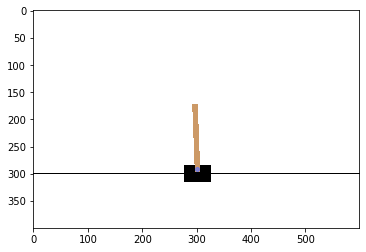

In [6]:
# Runner block also has special method to play one game in the environment and record everything
rollout = agent.play(render=True)

In [7]:
rollout

Rollout of length 19 of size 1. Additional information stored: {'frames'}

In [8]:
rollout.keys()

dict_keys(['frames', 'observations', 'actions', 'rewards', 'discounts'])

# Visualization

**Composed** allows us to unite several blocks in one. For example, we can use it to have not only ***Runner***, but also a ***Visualizer*** in our system.

One iteration for **Composed** module is just calling _iteration_ method from all incorporated modules. \
*timer* parameter for visualizer tells system to call it only once in 100 frames.

In [9]:
agent = Composed(
    Runner(),
    Visualizer(timer=100)
)

In [10]:
system = System(agent, env)

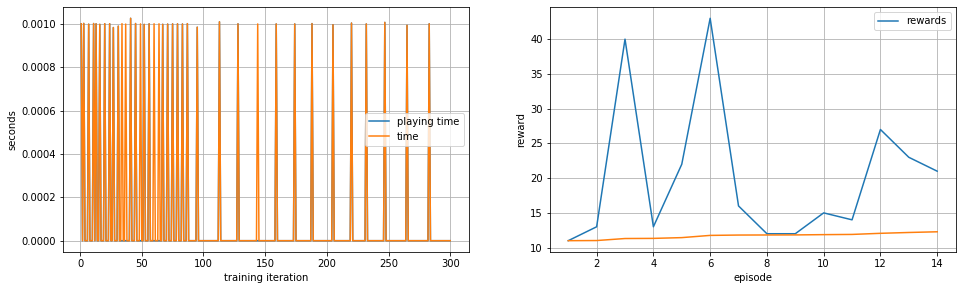

In [11]:
# run 300 iterations
system.run(300)

System also stores all logs from session.

In [12]:
system.logger.keys()

dict_keys(['playing time', 'time', 'rewards', 'episode ends'])

In [13]:
system.logger['rewards']

[11.0,
 13.0,
 40.0,
 13.0,
 22.0,
 43.0,
 16.0,
 12.0,
 12.0,
 15.0,
 14.0,
 27.0,
 23.0,
 21.0]

# DQN

Now, DQN in this paradigm consists of many, many blocks...

In [14]:
visualizer      = Visualizer()
backbone        = Backbone(CartpoleNN())
q_head          = QualityHead(backbone=backbone)
policy          = eGreedy(greedy_policy=q_head)
runner          = Runner(policy=policy)  
replay          = ReplayBuffer(runner=runner)
sampler         = Sampler(replay=replay)
target_backbone = Frozen(Backbone)(source=backbone)
target          = Frozen(QualityHead)(source=q_head, backbone=target_backbone)
critic_loss     = OptimalCriticLoss(sampler=sampler, critic=q_head, target_critic=target)
trainer         = Trainer(backbone=backbone, losses=[critic_loss])

In [15]:
type(target_backbone).__qualname__

'Frozen.<locals>.Frozen'

Why so many? It is important to split simple algorithm like DQN to many parts in order to reuse this code in modifications and other algorithms.

Let's unite them in one **Composed** module and look what each of them is doing:

In [16]:
agent = Composed(visualizer, backbone, q_head, policy, runner, replay, sampler, target_backbone, target, critic_loss, trainer)

In [17]:
agent

<visualizer>: Plots logs every 100 iteration
<backbone>: Backbone of network
<qualityhead>: Head, connected to <backbone>, modeling Q
<egreedy>: Acts randomly with eps-probability, otherwise calls <qualityhead>
<runner>: Makes one step in parallel environments each 1 iteration using <egreedy>
<replaybuffer>: Stores observations from <runner>
<sampler>: Samples mini-batches from <replaybuffer>
<frozenbackbone>: Copy of <backbone>, updated each 100 iteration
<frozenqualityhead>: Copy of <qualityhead>, updated each 100 iteration
<optimalcriticloss>: Calculates one-step optimal TD loss for <qualityhead> using <frozenqualityhead> as target calculator and data from <sampler>
<trainer>: Trains <backbone> with all heads using following losses: <optimalcriticloss>

There are several hints why these modules are separated:
* we might want to connect another head to **backbone** of network, like actor head for policy gradient algorithms or somve world dynamics decoder.
* we might want to use another Q-function representation like in Categorical DQN or Quantile Regression DQN
* we might want to change or turn off **eGreedy** exploration strategy
* we might want to change **replayBuffer** and store $N$-step transitions like in Multi-Step DQN.
* we might want to change **sampler** strategy by using, for example, prioritized replay.
* we might use this **replayBuffer** to sample mini-batches for another losses, heads or even optimization procedures.
* we might turn on or off target network heuristic (**frozen** module), or use it as policy (because it is also a qHead...).
* we might update **optimalCriticLoss** like in Double DQN
* finally, **trainer** is the module that on each *iteration* calls all loss functions provided and performs one step of gradient optimization 

In [18]:
# initialization: we have some logs about connecting qHead to backbone.
system = System(agent, env)

Adding new head <qualityhead> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


In [19]:
system.run(debug=True)

runner: plays one step.
  qualityhead: received act query.
  backbone: forward pass for state computed
  qualityhead: forward pass for state computed
  egreedy: mixing some exploration in...
replaybuffer: adds new observations from runner
trainer: initiates loss computation.
  sampler: Cold Start regime: batch is not sampled.
  optimalcriticloss: no batch is found, loss is None.
trainer: loss is None; no optimization step is performed.


..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


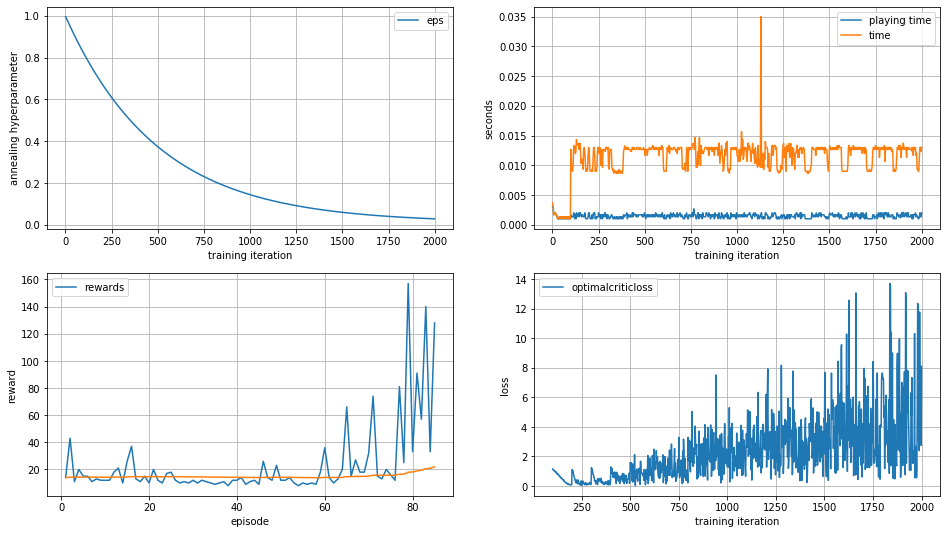

In [20]:
# run 2000 iterations
system.run(2000)

In [21]:
# store model
system.save("models/cartpole_dqn")

# Composed modules

Why is this convinient? Convinience comes from possibility of uniting modules in more advanced **Composed** modules.

Our goal for today will be ___Twin DQN___ algorithm, where two DQNs are trained in parallel and used as next state evaluators for each other.

Obviously, we do not want to list all modules for more complicated systems. So, let's unite some of them in one DQN **Composed** module:

In [22]:
def DQN(NN, replay, target_critic=None):
    sampler  = Sampler(replay=replay)
    backbone = Backbone(NN)
    q_head   = QualityHead(backbone=backbone)
    dqn_loss = DoubleCriticLoss(sampler=sampler, critic=q_head, target_critic=target_critic)
    trainer  = Trainer(backbone=backbone, losses=[dqn_loss])
    
    return Composed(sampler, backbone, q_head, dqn_loss, trainer)

Here there is a problem: DQN must have a link to ***replay buffer***, which takes data from ***Runner***, which requires a policy... which requires DQN. You got the idea.

So here is some fancy _referencing via names_ that we support.

In [23]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    dqn             = DQN(CartpoleNN(), replay="replay", target_critic="target"),
    target_backbone = Frozen(Backbone)(source="dqn.backbone"),
    target          = Frozen(QualityHead)(source="dqn.qualityhead", backbone="target_backbone"),
    policy          = eGreedy(greedy_policy="dqn.qualityhead"),
)

What happened here? Let's look!

In [24]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in parallel environments each 1 iteration using <policy>
<replay>: Stores observations from <runner>
<dqn>:
    <sampler>: Samples mini-batches from <replay>
    <backbone>: Backbone of network
    <qualityhead>: Head, connected to <backbone>, modeling Q
    <doublecriticloss>: Calculates Double DQN loss for <qualityhead> using <target> as estimator and data from <sampler>
    <trainer>: Trains <backbone> with all heads using following losses: <doublecriticloss>
    
<target_backbone>: Copy of <dqn.backbone>, updated each 100 iteration
<target>: Copy of <dqn.qualityhead>, updated each 100 iteration
<policy>: Acts randomly with eps-probability, otherwise calls <dqn.qualityhead>

We can dive a bit inside by navigating through the *modules tree*:

In [25]:
agent['dqn']

<sampler>: Samples mini-batches from <replay>
<backbone>: Backbone of network
<qualityhead>: Head, connected to <backbone>, modeling Q
<doublecriticloss>: Calculates Double DQN loss for <qualityhead> using <target> as estimator and data from <sampler>
<trainer>: Trains <backbone> with all heads using following losses: <doublecriticloss>

In [26]:
agent['dqn']['sampler'].__dict__

{'timer': 1,
 'frozen': False,
 'performed': False,
 'replay': Reference at RLmodule named replay. It will be changed to direct link after system initialization,
 'batch_size': 32,
 'cold_start': 100,
 '_sample': None,
 'name': 'sampler'}

For **Sampler** module, there are some hyperparamethers (*frozen*=True will mean that module does nothing each iteration; *timer* will mean that it will only work each $t$-th iteration; *batch_size* and *cold_start* are hyperparameters)...

Also, there is an interesting field *_sample*, which is where the module stores sampled mini-batch. In our paradigm, sampler does not know what modules in the system require this mini-batch. Even if he is provided with the list of links (I've tried this option...), then triggered modules might not have all necessary information at the moment when the batch is sampled. Instead of some complicated synchronization mechanism, the idea is the following: **Sampler** stores the batch in his *_sample* field, and all modules requiring it *reference* **Sampler** and look for this property.

Similarly **Sampler** communicates with **ReplayBuffer** by storing a direct link to it. Unfortunately, we did not have a direct link to **ReplayBuffer**, so instead there is a *Reference*.  

In [27]:
agent['dqn']['sampler'].replay

Reference at RLmodule named replay. It will be changed to direct link after system initialization

Let's initialize our **System**!

In [28]:
system = System(agent, env)

Adding new head <dqn.qualityhead> to <dqn.backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


Now, let's look what happened:

In [29]:
agent['dqn']['sampler'].replay

Stores observations from <runner>

In [30]:
type(agent['dqn']['sampler'].replay)

LegoRL.buffers.replayBuffer.ReplayBuffer

In [31]:
agent['dqn']['sampler'].replay is agent['replay']

True

We can use such referencing for convinient initialization of our agents now!

# Twin DQN

In [32]:
DQN = lambda NN, replay, target_critic=None: Composed(
    sampler  = Sampler(replay=replay),
    backbone = Backbone(NN),
    q_head   = QualityHead(backbone="backbone"),
    dqn_loss = DoubleCriticLoss(sampler="sampler", critic="q_head", target_critic=target_critic),
    trainer  = Trainer(backbone="backbone", losses=["dqn_loss"])
)

In [33]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="policy"),
    replay     = ReplayBuffer(runner="runner"),
    dqn        = DQN(CartpoleNN(), replay="replay", target_critic="dqn2.q_head"),
    dqn2       = DQN(CartpoleNN(), replay="replay", target_critic="dqn.q_head"),
    policy     = eGreedy(greedy_policy="dqn.q_head"),
)

Now we have TWO **Backbone**s in our system, so there will be TWO logs about connections from **System** during initialization:

In [34]:
system = System(agent, env)

Adding new head <dqn.q_head> to <dqn.backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])
Adding new head <dqn2.q_head> to <dqn2.backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


In [35]:
# look at list of all modules with their description
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in parallel environments each 1 iteration using <policy>
<replay>: Stores observations from <runner>
<dqn>:
    <sampler>: Samples mini-batches from <replay>
    <backbone>: Backbone of network
    <q_head>: Head, connected to <dqn.backbone>, modeling Q
    <dqn_loss>: Calculates Double DQN loss for <dqn.q_head> using <dqn2.q_head> as estimator and data from <dqn.sampler>
    <trainer>: Trains <dqn.backbone> with all heads using following losses: <dqn.dqn_loss>
    
<dqn2>:
    <sampler>: Samples mini-batches from <replay>
    <backbone>: Backbone of network
    <q_head>: Head, connected to <dqn2.backbone>, modeling Q
    <dqn_loss>: Calculates Double DQN loss for <dqn2.q_head> using <dqn.q_head> as estimator and data from <dqn2.sampler>
    <trainer>: Trains <dqn2.backbone> with all heads using following losses: <dqn2.dqn_loss>
    
<policy>: Acts randomly with eps-probability, otherwise calls <dqn.q_head>

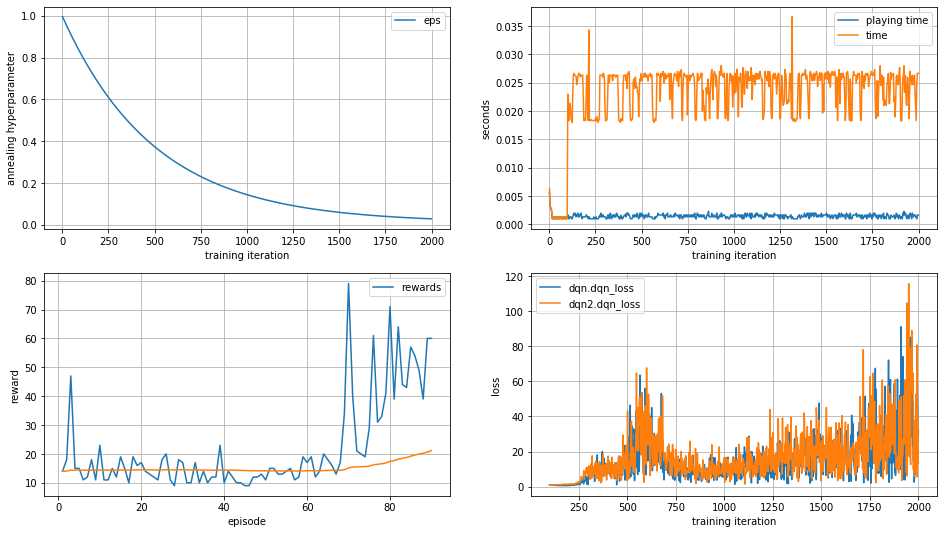

In [36]:
# train for 2000 iterations
system.run(2000)

In [37]:
# play one game and sum rewards
rollout = agent['runner'].play()
sum(rollout.rewards)

array([54.], dtype=float32)

In [38]:
rollout

Rollout of length 54 of size 1. Additional information stored: {'frames', 'dqn.backbone output for state', 'dqn.q_head output for state'}

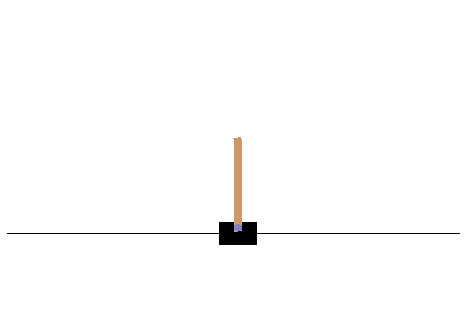

In [39]:
# displaying using HTML
show_animation(rollout['frames'])

In [40]:
# saving
system.save("models/twindqn")

# Fancy stuff with *timer*

Suppose we now want to have fewer interactions with environment. All we need to do is change **Runner**'s *timer*:

In [41]:
agent['runner'].timer = 30

In [42]:
agent['runner']

Makes one step in parallel environments each 30 iteration using <policy>

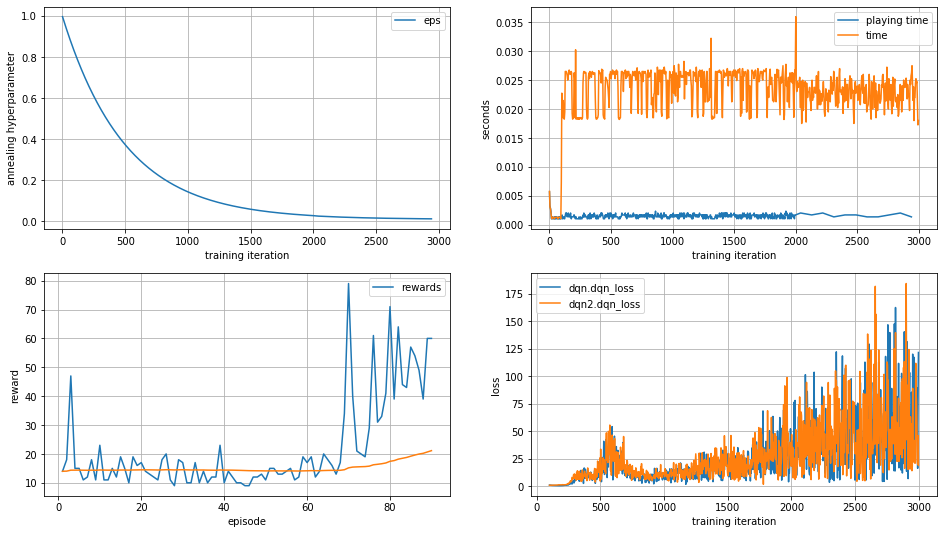

In [43]:
# train for 1000 more iterations
# (almost) no new rewards appear on rewards plot from Runner
# "playing time" plot also has much less points now
system.run(1000)

In [44]:
# we stored a bit more than 2000 transitions
len(agent['replay'])

2034

We can even turn **Runner** off. Its *iteration* method will not be called.

In [45]:
agent['runner'].frozen = True

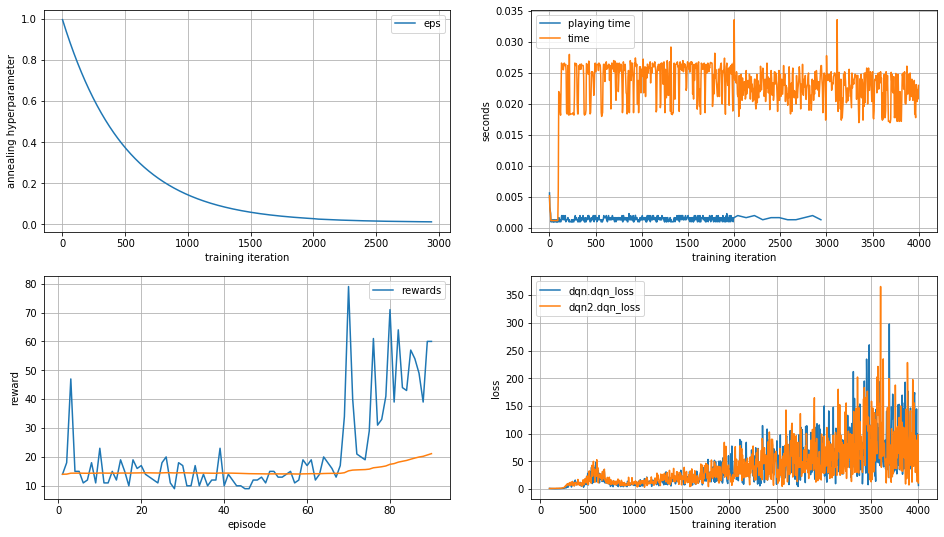

In [46]:
# train for 1000 more iterations
# no more new rewards, no more points on "playing time" plot
system.run(1000)

In [47]:
# no new observations!
len(agent['replay'])

2034

# Looking inside batch

One more important detail.

In [48]:
# last sampled batch is stored here
batch = agent['dqn']['sampler'].sample()

In [49]:
batch.keys()

dict_keys(['states', 'actions', 'rewards', 'next_states', 'discounts', 'dqn.backbone output for state', 'dqn.q_head output for state', 'dqn.backbone output for last state', 'dqn.q_head output for last state', 'dqn2.backbone output for last state', 'dqn2.q_head output for last state', 'dqn.dqn_loss loss'])

As you can see, beside obvious properties (s, a, r, s', done, discounts), there are some more. \
It is a ***cache*** for our networks. It means that if the same **Backbone** or **qHead** is called again on this batch, this cache will be reused.

In [50]:
Q = batch['dqn.q_head output for state']
Q

Q-function for 2 actions

In [51]:
# shape is (32 x 2) which is (batch_size x num_actions)
# thie tensor is also differentiable
Q.tensor.shape

torch.Size([32, 2])

In [52]:
# We use PyTorch 1.3.0 (unstable) Named Tensors 
# to denote all dimensions in representation
Q.tensor.names

('batch', 'actions')

What cache allows us to do? **Do not think about the order of modules execution.** In A2C, policy loss uses outputs of the network because in pipeline critic loss is computed before it; in prioritized replay, calculated loss is used as priorities for sampler. Now all networks outputs will be cached and we can think about modules' logic other than data transmission between them.